In [2312]:
import keras
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense, Bidirectional, Dropout
from keras.layers import Embedding
import keras.backend as K

import numpy as np
import string
import csv
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import random


In [2313]:
url = "./datasets/pre_processed_dataset.csv"
names = ["tweet", "label"]
data = pd.read_csv(url,names=names)
data = data.drop(data.index[0])
data = data.sample(frac = 1)

In [2314]:
X = data['tweet']
y = data['label']

In [2315]:
y[y == 0] = 1

C:\Users\USER\AppData\Local\Temp\ipykernel_11916\4066623601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 0] = 1


In [2316]:
y[y == -1] = 0

C:\Users\USER\AppData\Local\Temp\ipykernel_11916\3153561895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == -1] = 0


In [2317]:
num_classes = 1

# Vectorization

In [2318]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [2319]:
# หาความยาวสูงสุดของ senence ใน tweets
max_length = max([len(word_tokenize(i)) for i in X])

In [2320]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [2321]:
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' %(vocab_size))

Found 2078 unique tokens.


In [2322]:
# integer encode the tweets
x_sequences = tokenizer.texts_to_sequences(X)

In [2323]:
# # encode the label
# y = keras.utils.to_categorical(y, num_classes)

In [2324]:
X = pad_sequences(x_sequences, maxlen=max_length)

# Split data

In [2325]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [2326]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214, 51), (214,), (38, 51), (38,))

In [2327]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

In [2328]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214, 51), (214,), (38, 51), (38,))

# LSTM

##### set parameter

In [2329]:
epochs=15
batch_size=10

## Create model 1

In [2330]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    CuDNNLSTM(64, return_sequences=True),

    CuDNNLSTM(64),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes,activation='sigmoid')
])

In [2331]:
# model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [2332]:
rmsprop = keras.optimizers.RMSprop(lr = .001)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\USER\anaconda3\envs\envtf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [2333]:
model.summary()

Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_191 (Embedding)   (None, 51, 32)            66496     
                                                                 
 cu_dnnlstm_387 (CuDNNLSTM)  (None, 51, 64)            25088     
                                                                 
 cu_dnnlstm_388 (CuDNNLSTM)  (None, 64)                33280     
                                                                 
 dense_380 (Dense)           (None, 128)               8320      
                                                                 
 dropout_458 (Dropout)       (None, 128)               0         
                                                                 
 dense_381 (Dense)           (None, 1)                 129       
                                                                 
Total params: 133,313
Trainable params: 133,313
Non-

In [2334]:
# from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=4)

## train model1

In [2335]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/15
22/22 [==============================] - 2s 35ms/step - loss: 0.6951 - accuracy: 0.4766 - val_loss: 0.6928 - val_accuracy: 0.6053
Epoch 2/15
22/22 [==============================] - 0s 14ms/step - loss: 0.6943 - accuracy: 0.4673 - val_loss: 0.6947 - val_accuracy: 0.4737
Epoch 3/15
22/22 [==============================] - 0s 16ms/step - loss: 0.6870 - accuracy: 0.6636 - val_loss: 0.6897 - val_accuracy: 0.5789
Epoch 4/15
22/22 [==============================] - 0s 13ms/step - loss: 0.5415 - accuracy: 0.8458 - val_loss: 0.7117 - val_accuracy: 0.5526
Epoch 5/15
22/22 [==============================] - 0s 13ms/step - loss: 0.1921 - accuracy: 0.9346 - val_loss: 0.9335 - val_accuracy: 0.5000
Epoch 6/15
22/22 [==============================] - 0s 14ms/step - loss: 0.0557 - accuracy: 0.9766 - val_loss: 1.3366 - val_accuracy: 0.5000
Epoch 7/15
22/22 [==============================] - 0s 13ms/step - loss: 0.0499 - accuracy: 0.9860 - val_loss: 1.1620 - val_accuracy: 0.5263
Epoch 8/15
22

In [2336]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 1.6949 - accuracy: 0.5000


[1.6949058771133423, 0.5]

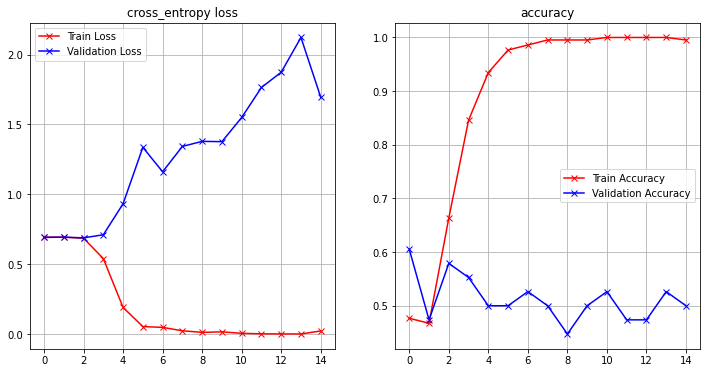

In [2337]:
plot_loss_accuracy(history)

# LSTM biderectional

## Create model 2

In [2338]:
model_2 = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    Bidirectional(CuDNNLSTM(64, return_sequences=True)),

    Bidirectional(CuDNNLSTM(64)),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes,activation='sigmoid')
])

In [2339]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [2340]:
model_2.summary()

Model: "sequential_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_192 (Embedding)   (None, 51, 32)            66496     
                                                                 
 bidirectional_180 (Bidirect  (None, 51, 128)          50176     
 ional)                                                          
                                                                 
 bidirectional_181 (Bidirect  (None, 128)              99328     
 ional)                                                          
                                                                 
 dense_382 (Dense)           (None, 128)               16512     
                                                                 
 dropout_459 (Dropout)       (None, 128)               0         
                                                                 
 dense_383 (Dense)           (None, 1)              

## train model_2

In [2341]:
history_2 = model_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True,)

Epoch 1/15
22/22 [==============================] - 5s 55ms/step - loss: 0.6966 - accuracy: 0.4626 - val_loss: 0.6941 - val_accuracy: 0.4737
Epoch 2/15
22/22 [==============================] - 0s 21ms/step - loss: 0.6940 - accuracy: 0.5187 - val_loss: 0.6927 - val_accuracy: 0.4737
Epoch 3/15
22/22 [==============================] - 0s 21ms/step - loss: 0.6497 - accuracy: 0.7243 - val_loss: 0.9434 - val_accuracy: 0.4737
Epoch 4/15
22/22 [==============================] - 0s 23ms/step - loss: 0.2818 - accuracy: 0.9206 - val_loss: 1.4373 - val_accuracy: 0.6842
Epoch 5/15
22/22 [==============================] - 1s 26ms/step - loss: 0.0862 - accuracy: 0.9720 - val_loss: 0.9748 - val_accuracy: 0.7368
Epoch 6/15
22/22 [==============================] - 1s 25ms/step - loss: 0.1238 - accuracy: 0.9626 - val_loss: 1.1057 - val_accuracy: 0.5263
Epoch 7/15
22/22 [==============================] - 0s 19ms/step - loss: 0.0589 - accuracy: 0.9907 - val_loss: 1.0338 - val_accuracy: 0.6053
Epoch 8/15
22

In [2342]:
model_2.evaluate(x_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 1.1605 - accuracy: 0.7105


[1.160535454750061, 0.7105262875556946]

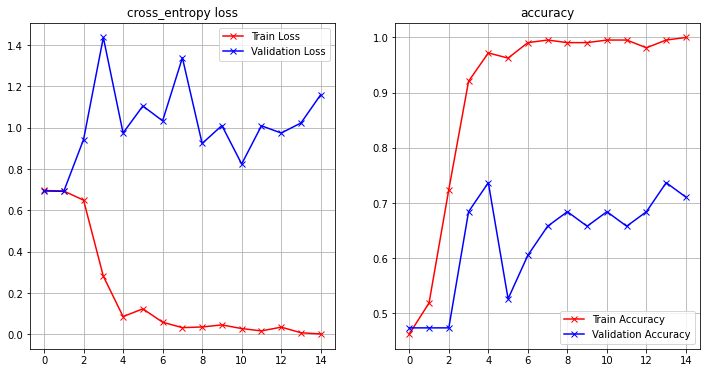

In [2343]:
plot_loss_accuracy(history_2)

# Performance metrics

In [2344]:
pred_model_1 = model.predict(x_test)
pred_model_2 = model_2.predict(x_test)

2/2 [==============================] - 0s 6ms/step


### 1. Recall score

In [2345]:
from sklearn.metrics import recall_score
print('recall score model 1 : ',recall_score(y_test, pred_model_1.round(), average='weighted'))
print('recall score model 2 : ',recall_score(y_test, pred_model_2.round(), average='weighted'))

recall score model 1 :  0.5
recall score model 2 :  0.7105263157894737


### 2. F1 score

In [2346]:
from sklearn.metrics import f1_score
print('recall score model 1 : ',f1_score(y_test, pred_model_1.round(), average='macro'))
print('recall score model 2 : ',f1_score(y_test, pred_model_2.round(), average='macro'))

recall score model 1 :  0.49119097956307256
recall score model 2 :  0.7103257103257103
